# Verification

In [1]:
# Convenient jupyter setup
%load_ext autoreload
%autoreload 2
%config IPCompleter.greedy=True

In [4]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
from sithom.plot import plot_defaults, label_subplots
from sithom.time import timeit
from src.conversions import si_ify, knots_to_ms
from src.constants import KATRINA_ERA5_NC, KATRINA_TIDE_NC, KAT_EX_PATH, NO_BBOX
from src.data_loading.ibtracs import kat_stats, katrina
from adcircpy.outputs import Maxele

/Users/simon/new-orleans/env/lib/python3.8/site-packages/geopandas/_compat.py:112: UserWarning: The Shapely GEOS version (3.10.2-CAPI-1.16.0) is incompatible with the GEOS version PyGEOS was compiled with (3.10.3-CAPI-1.16.1). Conversions between both will be slow.
  warnings.warn(


In [3]:
@np.vectorize
def indices_in_bbox(lon, lat):
    return (
        lon > NO_BBOX.lon[0]
        and lon < NO_BBOX.lon[1]
        and lat > NO_BBOX.lat[0]
        and lat < NO_BBOX.lat[1]
    )


## Tide Stations

In [7]:
tide_ds =  xr.open_dataset(KATRINA_TIDE_NC)
tide_ds

<xarray.Dataset>
Dimensions:      (date_time: 3121, stationid: 7)
Coordinates:
  * date_time    (date_time) datetime64[ns] 2005-08-20 ... 2005-09-02
    name         (stationid) object ...
  * stationid    (stationid) object '8729840' '8735180' ... '8762482' '8764044'
    lon          (stationid) float64 ...
    lat          (stationid) float64 ...
Data variables:
    flags        (stationid, date_time) object ...
    QC           (stationid, date_time) object ...
    water_level  (stationid, date_time) float64 ...
    sigma        (stationid, date_time) float64 ...

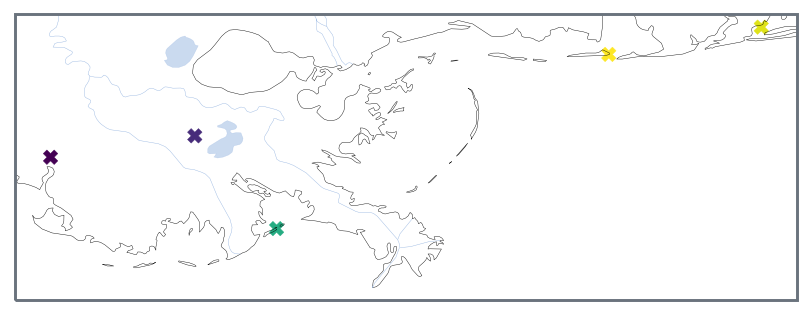

In [10]:
from src.plot.map import map_axes
from sithom.plot import plot_defaults
plot_defaults()
map_axes()
plt.scatter(tide_ds.lon.values, tide_ds.lat.values, c=tide_ds.isel(date_time=2000).water_level.values)

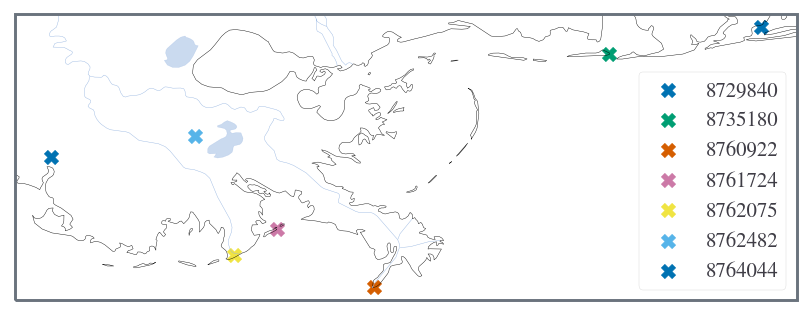

In [11]:
plot_defaults()
map_axes()
for i in range(len(tide_ds.lon.values)):
    tmp_ds = tide_ds.isel(stationid=i)
    plt.scatter(tmp_ds.lon.values, tmp_ds.lat.values, label=str(tmp_ds.stationid.values))
    
plt.legend()

In [18]:
gi = tide_ds.sel(stationid="8761724")
gi

<xarray.Dataset>
Dimensions:      (date_time: 3121)
Coordinates:
  * date_time    (date_time) datetime64[ns] 2005-08-20 ... 2005-09-02
    name         object 'Grand Isle'
    stationid    <U7 '8761724'
    lon          float64 -89.96
    lat          float64 29.26
Data variables:
    flags        (date_time) object '1,0,0,0' '0,0,0,0' ... '0,0,0,0' '1,0,0,0'
    QC           (date_time) object 'v' 'v' 'v' 'v' 'v' ... 'v' 'v' 'v' 'v' 'v'
    water_level  (date_time) float64 -0.239 -0.244 -0.243 ... -0.16 -0.163
    sigma        (date_time) float64 0.0 0.004 0.005 0.004 ... 0.002 0.002 0.0

## Find Corresponding Mesh Point

In [13]:
import os

In [14]:
os.listdir(KAT_EX_PATH)

['minpr.63.nc',
 'maxwvel.63.nc',
 'windDrag.173.nc',
 'fort.73.nc',
 'fort.63.nc',
 'fort.22',
 'fort.14',
 'maxvel.63.nc',
 'fort.15',
 'fort.218',
 'fort.221',
 'fort.217',
 'run.sh',
 'adcirc_log.txt',
 'maxele.63.nc',
 'comparison.log',
 'fort.33',
 'fort.74.nc',
 'fort.64.nc',
 'fort.16',
 'control',
 'fort.224',
 'fort.223',
 'fort.222']

In [15]:
me = Maxele(os.path.join(KAT_EX_PATH, "maxele.63.nc"))

In [17]:
local_indices = indices_in_bbox(me.x, me.y)

In [21]:
global_index = ((gi.lon.values - me.x) **2 + (gi.lat.values - me.y)**2).argmin()
global_index

4993

In [23]:
local_index = ((gi.lon.values - me.x[local_indices]) **2 + (gi.lat.values - me.y[local_indices])**2).argmin()
local_index

120

In [24]:
print(me.x[global_index], me.y[global_index])
print(gi.lon.values, gi.lat.values)

-89.93858590820001 29.2449848667
-89.957 29.263


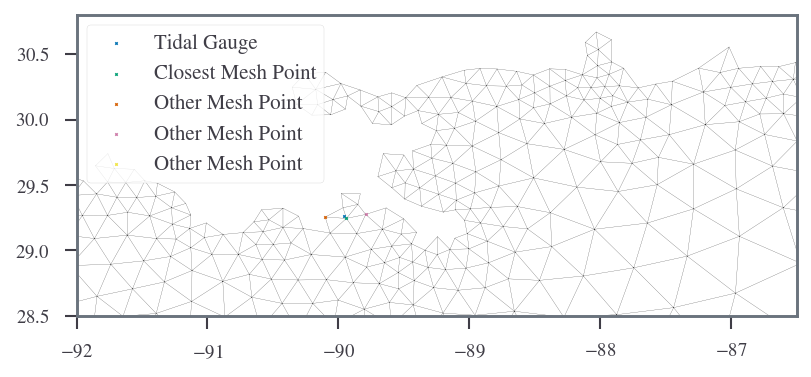

In [69]:
me.triplot()
NO_BBOX.ax_lim(plt.gca())
s=2
plt.scatter(gi.lon.values, gi.lat.values, label="Tidal Gauge", s=s)
plt.scatter(me.x[global_index], me.y[global_index], label="Closest Mesh Point", s=s)
plt.scatter(me.x[global_index+1], me.y[global_index+1], label="Close Coastal Mesh Point", s=s)
plt.scatter(me.x[global_index-1], me.y[global_index-1], label="Close Coastal Mesh Point", s=s)
plt.scatter(me.x[global_index+o], me.y[global_index+o], label="Close Coastal Mesh Point", s=s)

plt.legend()

## Comparing ADCIRC exampel Fort.63 file to tidal gauge 

In [25]:
from adcircpy.outputs import Fort63

In [28]:
f63 = Fort63(os.path.join(KAT_EX_PATH, "fort.63.nc"))

Text(0.5, 0, 'Time Index')

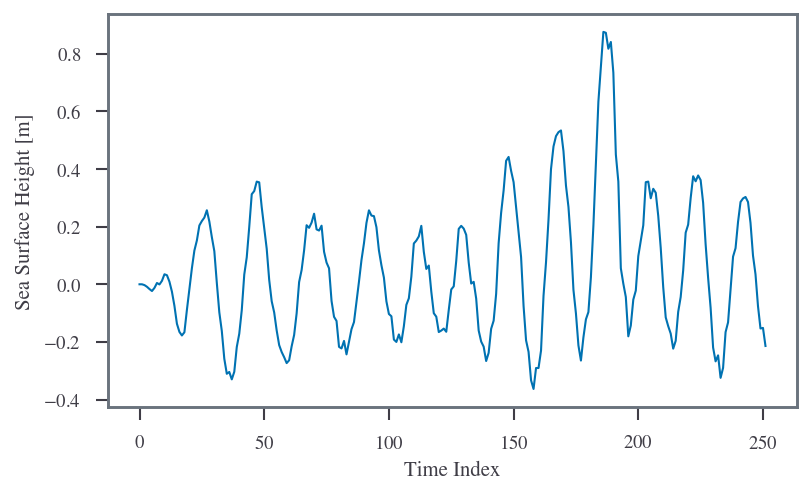

In [50]:
plt.plot(f63._ptr["zeta"][:, global_index])
plt.ylabel("Sea Surface Height [m]")
plt.xlabel("Time Index")

Text(0.5, 0, 'Time Index')

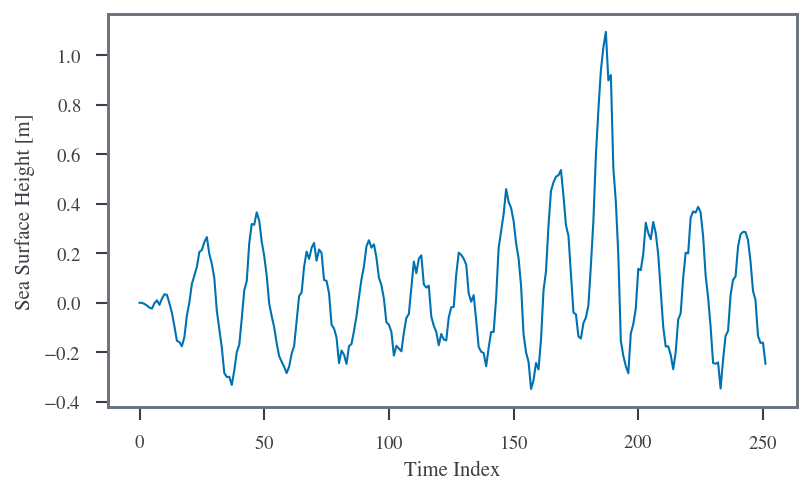

In [51]:
plt.plot(f63._ptr["zeta"][:, global_index-1])
plt.ylabel("Sea Surface Height [m]")
plt.xlabel("Time Index")

Text(0.5, 0, 'Time Index')

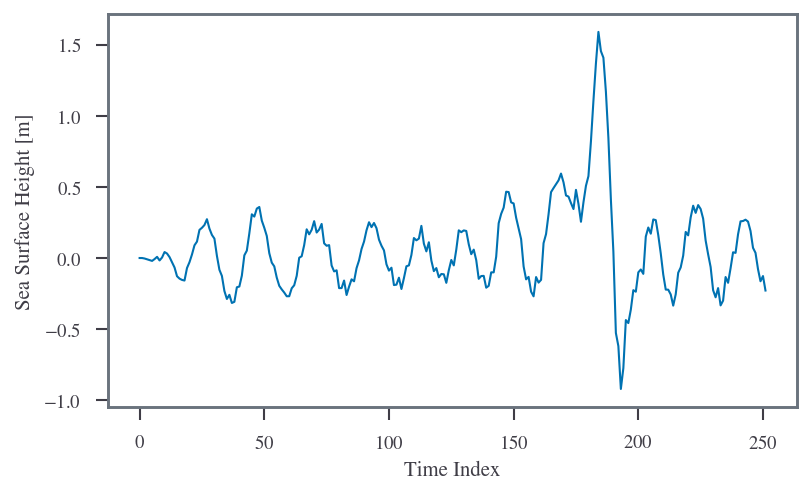

In [52]:
plt.plot(f63._ptr["zeta"][:, global_index+1])
plt.ylabel("Sea Surface Height [m]")
plt.xlabel("Time Index")

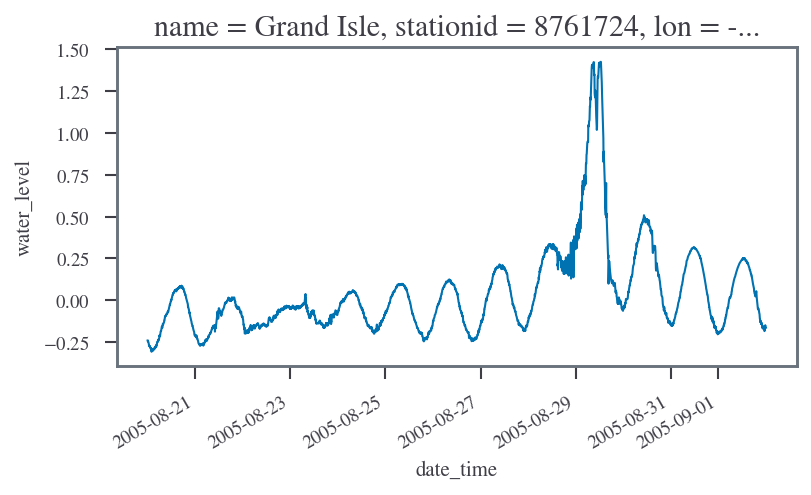

In [31]:
gi.water_level.plot()